#### AB - test final project

For your **final project**, you need to implement an experiment evaluation service.

You have data on users and their purchases over 5 weeks. In the sixth week, a series of experiments will be conducted. Their goal is to increase the average revenue per customer. The service's task is to determine whether to implement the change or not.

Your service will be launched with the command ```FLASK_APP=user_input/solution.py flask run --port 11000```, where solution.py is your solution file that you upload. On the submission page, a Dockerfile is available describing the environment for running. You can check library versions for local debugging.

You will have 120 seconds for data loading and preprocessing.

During these 120 seconds, requests will be sent to the ```/ping``` endpoint. The endpoint is a web page at ```127.0.0.1:11000/ping```. As soon as the server responds with JSON containing key status and value ok, the solution verification will begin.

During verification, POST requests will be sent to the ```/check_test``` endpoint with user identifiers for control and experimental groups. Example request content: ```{'test': {'a': [1, 2, 3], 'b': [4, 5, 6]}}```. In response, the ```/check_test``` endpoint should return JSON of the form ```{'has_effect': 1}``` with value 1 if there is an effect, otherwise 0.

- Memory limit: 3GB. 
- The sales information file size is 12MB. 
- The server must start within 120 seconds. 
- The response time for one /check_test request should not exceed 1 second.

#### Information about experiments:

- We consider experiments to be independent of each other;
- Experiments were conducted in the sixth week, from day 36 to 42 inclusive;
- Group sizes are around 100-120 users;
- When designing experiments, it was assumed that a two-sided Student's t-test with significance level 0.05 would be applied;
- Groups for some experiments might be selected not from the entire population, but from some subset. For example, new customers who haven't made purchases before.

You will need to evaluate 1000 experiments in total. The assignment score will be calculated based on the number of incorrectly evaluated experiments according to the table:

In [1]:
import os
import json

import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from typing import Tuple, Dict, List

PATH_FILE = 'df_sales_public.csv'

In [2]:
df_sales = pd.read_csv(PATH_FILE)

In [ ]:
# define feature extractors to build Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

class FunctionalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, function, **params):
        self.function = function
        self.params = params

    def fit(self, X, y=None):
        return self

    def transform(self, X, **kwargs):
        return self.function(X, **self.params)

    def get_params(self, deep=True):
        return {"function": self.function, **self.params}

    def set_params(self, **params):
        for key, value in params.items():
            if key == "function":
                self.function = value
            else:
                self.params[key] = value
        return self

    def set_output(self, **params):
        return self
    
def functional_transformer(function):
    def builder(**params):
        return FunctionalTransformer(function, **params)
    return builder

@functional_transformer
def get_features(df:pd.DataFrame, first_exp_day:int, lookback_window:int=7, forward_window:int=7)->pd.DataFrame:
    global DEFAULT_STRAT
    # preperiod
    day_filter = np.arange(first_exp_day - lookback_window, first_exp_day)

    result = (df.loc[lambda x: x['day'].isin(day_filter)]
                .groupby('user_id')
                .agg(cost_mean=('cost', 'mean'),
                     cost_sum=('cost', 'sum'),
                     purchase_count=('cost', 'count')))
    
    df_channel = (df.loc[lambda x: x['day'].isin(day_filter)]
                    .assign(channel = lambda x: 'channel_' + x['channel'].astype(str))
                    .pivot_table(index='user_id', 
                                columns=['channel'], 
                                values='cost', 
                                aggfunc='sum')
                    .fillna(0))

    df_channel.columns = [''.join(col).strip() for col in df_channel.columns]
    result = result.join(df_channel)

    result = (result.assign(strat=lambda x: x.index.map(user_by_strat).fillna(DEFAULT_STRAT)))

    # post period
    day_filter = np.arange(first_exp_day, first_exp_day + forward_window)
    target = (df.loc[lambda x: x['day'].isin(day_filter)]
                .groupby('user_id')
                .agg(target=('cost', 'sum')))
    
    result = result.join(target)
    return result


In [3]:
def calculate_theta(y_pilot,  y_pilot_cov) -> float:
    """Вычисляем Theta.

    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    y_control_cov - значения ковариант на контрольной группе
    y_pilot_cov - значения ковариант на пилотной группе
    """
    if not isinstance(y_pilot, np.ndarray):
        y_pilot = np.array(y_pilot).flatten()
    if not isinstance(y_pilot_cov, np.ndarray):
        y_pilot_cov = np.array(y_pilot_cov).flatten()

    y = y_pilot
    y_cov = y_pilot_cov

    covariance = np.cov(y_cov, y)[0, 1]
    variance = y_cov.var()
    theta = covariance / variance
    return float(theta)

# FULL pipe

df_sales = pd.read_csv(PATH_FILE)

# define strats data
DEFAULT_STRAT = 2
get_strat = lambda x: np.where(x.isin([0,1]), x, DEFAULT_STRAT)
user_strat = (df_sales.assign(strat = lambda x: get_strat(x['channel']))
                      .groupby(['user_id', 'strat'])
                      .agg(cnt=('day', 'count'))
                      .reset_index()
                      .sort_values(['user_id', 'cnt'], ascending=False)
                      .drop_duplicates('user_id', keep='first'))
strat_weights = user_strat.value_counts('strat', normalize=True)
user_strat = (user_strat.assign(weight=lambda x: x['strat'].map(strat_weights))
                         .set_index('user_id')
                        #  
                         )
user_by_strat = user_strat['strat'].to_dict()


# define strat validation
def valid_strats(a_strats, b_strats, min_strat_size=10)->bool:
    # func check if a b groups are proper to stratification 
    a_set, b_set = set(a_strats), set(b_strats)
    # all group have same strats
    if a_set != b_set:
        return False
    # all group have more then one strat
    if len(a_set) < 2:
        return False
    # all strats have minimum size
    if any([i < min_strat_size for i in Counter(a_strats).values()]):
        return False
    if any([i < min_strat_size for i in Counter(b_strats).values()]):
        return False
    return True

# calculate strat mean and variance
def calc_strat_mean_var(df, weights)->Tuple:
    '''
    :param df: - dataframe {metric: [], strat: []}
    :param weights: - dict({'strat_1': weight, 'strat_2':'weigth' ... })

    :return tuple(mean, var): stratified mean and var
    '''
    mean = df.groupby('strat')['metric'].mean()
    strat_mean = (mean * weights).sum()
    var = df.groupby('strat')['metric'].var()
    strat_var = (var * weights).sum()
    return strat_mean, strat_var

# define strat T-test
def strat_ttest(df_a, df_b, weights, alpha)->int:
    '''
    :param df_a: - dataframe {metric: [], strat: []}
    :param df_b: - dataframe {metric: [], strat: []}
    :param weights: - dict({'strat_1': weight, 'strat_2':'weigth' ... })
    :alpha: significance level
    
    :return int: 1 - present positive effect, 0 - absent positive effect
    '''
    mean_a, var_a = calc_strat_mean_var(df_a, weights)
    mean_b, var_b = calc_strat_mean_var(df_b, weights)
    delta = mean_b - mean_a
    std = (var_a / len(df_a) + var_b / len(df_b)) ** 0.5
    left_bound = delta - stats.norm.ppf(1-alpha/2) * std
    return int(left_bound>0)


# define metric
user_id_2_metric = df_sales.groupby('user_id')['cost'].sum().to_dict()
get_metric = lambda user_id: user_id_2_metric.get(user_id, 0)
get_strat = lambda user_id: user_by_strat.get(user_id, DEFAULT_STRAT)

### EDA

In [75]:
data = pd.read_csv(PATH_FILE)

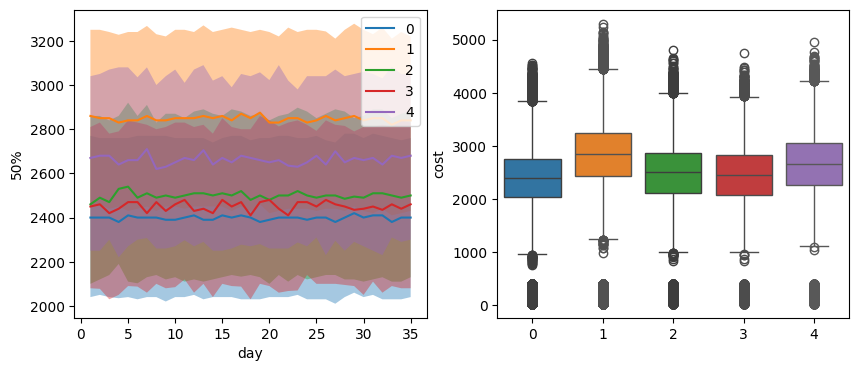

In [76]:
df_gb = data.groupby(['channel', 'day'])['cost'].describe()[['25%', '50%', '75%']].reset_index()


fig, axes = plt.subplots(1,2, figsize=(10,4))
axes = iter(axes.flatten())
ax1, ax2 = axes

for c in df_gb['channel'].unique():
    df_plot = df_gb.loc[lambda x: x['channel'] == c]
    sns.lineplot(data=df_plot, x='day', y='50%', label=c, ax=ax1)
    ax1.fill_between(x=df_plot['day'], y1=df_plot['25%'], y2=df_plot['75%'], alpha=0.4)
    sns.boxplot(y=data.loc[lambda x: x['channel']==c]['cost'], x=c)

# ax2.set_ylim(ax1.get_ylim())

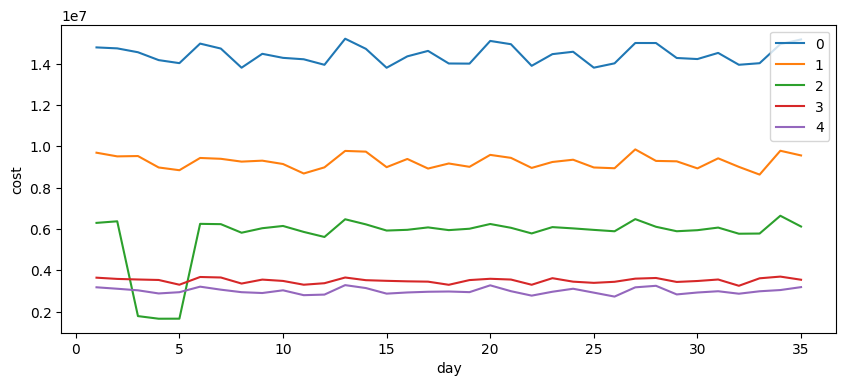

In [570]:
df_gb = data.groupby(['channel', 'day'])['cost'].sum().reset_index()


fig, axes = plt.subplots(figsize=(10,4))

for c in df_gb['channel'].unique():
    df_plot = df_gb.loc[lambda x: x['channel'] == c]
    sns.lineplot(data=df_plot, x='day', y='cost', label=c, ax=axes)

### Stratification

In [ ]:
# sample simulation
def sample_ab(size=100):
    a = np.random.choice(data['user_id'].drop_duplicates(), size=size*2) 
    return a[:size], a[size:]

a, b = sample_ab()

(100,)

In [254]:
# find startification weights
DEFAULT_STRAT = 2
get_strat = lambda x: np.where(x.isin([0,1]), x, DEFAULT_STRAT)
user_strat = (df_sales.assign(strat = lambda x: get_strat(x['channel']))
                      .groupby(['user_id', 'strat'])
                      .agg(cnt=('day', 'count'))
                      .reset_index()
                      .sort_values(['user_id', 'cnt'], ascending=False)
                      .drop_duplicates('user_id', keep='first'))
strat_weights = user_strat.value_counts('strat', normalize=True)
user_strat = (user_strat.assign(weight=lambda x: x['strat'].map(strat_weights))
                         .set_index('user_id')
                        #  
                         )
weights_by_user = user_strat['weight'].to_dict()
user_by_strat = user_strat['strat'].to_dict()

# user_by_strat, weights_by_user

In [ ]:
# validate sample to make stratified test
from collections import Counter

def valid_strats(a_strats, b_strats, min_strat_size=10):
    # func check if a b groups are proper to stratification 
    a_set, b_set = set(a_strats), set(b_strats)
    # all group have same strats
    if a_set != b_set:
        return False
    # all group have more then one strat
    if len(a_set) < 2:
        return False
    # all strats have minimum size
    if any([i < min_strat_size for i in Counter(a_strats).values()]):
        return False
    if any([i < min_strat_size for i in Counter(b_strats).values()]):
        return False
    return True

a, b = sample_ab(size=100)
a_strats = [get_strat(i) for i in a]
b_strats = [get_strat(i) for i in b]
print(Counter(a_strats), Counter(b_strats))
valid_strats(a_strats, b_strats)

Counter({0: 45, 2: 33, 1: 22}) Counter({2: 40, 0: 38, 1: 22})


True

In [ ]:
# calculate stratification mean and variation
user_id_2_metric = df_sales.groupby('user_id')['cost'].sum().to_dict()
get_metric = lambda user_id: user_id_2_metric.get(user_id, 0)
get_strat = lambda user_id: user_by_strat.get(user_id, DEFAULT_STRAT)

def calc_strat_mean_var(df, weights):
    mean = df.groupby('strat')['metric'].mean()
    strat_mean = (mean * weights).sum()
    var = df.groupby('strat')['metric'].var()
    strat_var = (var * weights).sum()
    return strat_mean, strat_var

size = 100
a, b = sample_ab(size=size)
metrics_a = [get_metric(user_id) for user_id in a]
strat_a = [get_strat(user_id) for user_id in a]
df_a = pd.DataFrame({'metric': metrics_a, 'strat':strat_a})
mean_a, var_a = calc_strat_mean_var(df_a, strat_weights)
mean_a, var_a

(np.float64(12814.33231269051),
 np.float64(33689169.89329223),
 (np.float64(12814.33231269051), np.float64(33689169.89329223)))

DIFF=600


(0, 0, 0)

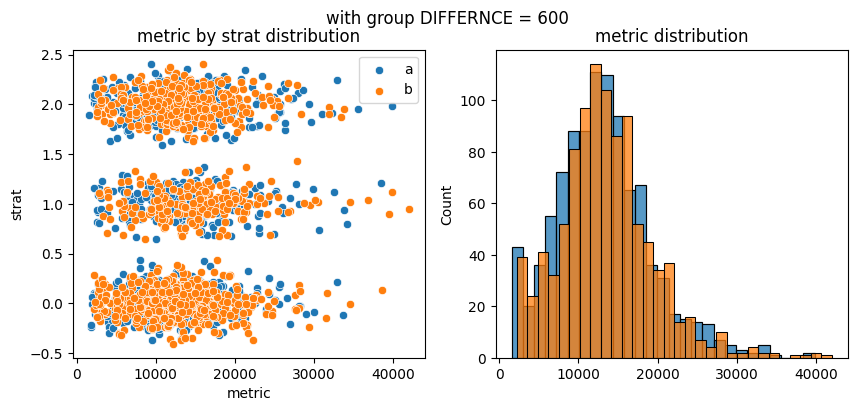

In [ ]:
# stratified T-test validation
ALPHA = 0.05

ttest = lambda a,b: int(stats.ttest_ind(a, b).pvalue < ALPHA)

def strat_ttest(df_a, df_b, weights, alpha):
    mean_a, var_a = calc_strat_mean_var(df_a, weights)
    mean_b, var_b = calc_strat_mean_var(df_b, weights)
    delta = mean_b - mean_a
    std = (var_a / len(df_a) + var_b / len(df_b)) ** 0.5
    left_bound = delta - stats.norm.ppf(1-alpha/2) * std
    return int(left_bound>0)

size = 1000
a, b = sample_ab(size=size)
diff = np.random.choice([600])

metrics_a = [get_metric(user_id) for user_id in a]
metrics_b = [get_metric(user_id) + np.random.normal(loc=diff, scale=diff/10) for user_id in b]
strat_a = [get_strat(user_id) for user_id in a]
strat_b = [get_strat(user_id) for user_id in b]

df_a = pd.DataFrame({'metric': metrics_a, 'strat':strat_a})
df_b = pd.DataFrame({'metric': metrics_b, 'strat':strat_b})

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes = iter(axes.flatten())

ax = next(axes)
jitter = np.random.normal(0, 0.15, size=size)
sns.scatterplot(x=df_a['metric'], y=df_a['strat'] + jitter, ax=ax, label='a')
sns.scatterplot(x=df_b['metric'], y=df_b['strat'] + jitter,  ax=ax, label='b')
ax.set_title(f"metric by strat distribution")

ax = next(axes)
sns.histplot(metrics_a, ax=ax, label='a'), sns.histplot(metrics_b, ax=ax, label='b')
ax.set_title(f"metric distribution")
plt.suptitle(f"with group DIFFERNCE = {diff}")

print(f'DIFF={diff}')
strat_ttest(df_a=df_a, df_b=df_b, weights=strat_weights, alpha=ALPHA),  ttest(metrics_a, metrics_b), run_strat_ttest(df_a=df_a, df_b=df_b, strat_weights=strat_weights, alpha=ALPHA)

In [ ]:
# main function for test
user_id_2_metric = df_sales.groupby('user_id')['cost'].sum().to_dict()
get_metric = lambda user_id: user_id_2_metric.get(user_id, 0)
get_strat = lambda user_id: user_by_strat.get(user_id, DEFAULT_STRAT)
ALPHA = 0.05

def check_test(a, b):
    """Проверяет гипотезу.
    
    :param a: список id пользователей контрольной группы
    :param b: список id пользователей экспериментальной группы
    :return: 1 - внедряем изменение, 0 - иначе.
    """
    metrics_a = [get_metric(user_id) for user_id in a]
    metrics_b = [get_metric(user_id) for user_id in b]
    strat_a = [get_strat(user_id) for user_id in a]
    strat_b = [get_strat(user_id) for user_id in b]
    if valid_strats(strat_a, strat_b):
        print('test valid')
        df_a = pd.DataFrame({'metric': metrics_a, 'strat':strat_a})
        df_b = pd.DataFrame({'metric': metrics_b, 'strat':strat_b})
        return strat_ttest(df_a, df_b, strat_weights, alpha=ALPHA)

    pvalue = stats.ttest_ind(metrics_a, metrics_b).pvalue
    delta = np.mean(metrics_b) - np.mean(metrics_a)
    return int((pvalue < ALPHA) and (delta > 0))


### find covariate

In [ ]:
first_exp_day, lookback_window = 36, 10

df = df_sales.copy()

# @functional_transformer
def get_features(df, first_exp_day, lookback_window=7, forward_window=7):
    global DEFAULT_STRAT
    # preperiod
    day_filter = np.arange(first_exp_day - lookback_window, first_exp_day)

    result = (df.loc[lambda x: x['day'].isin(day_filter)]
                .groupby('user_id')
                .agg(cost_mean=('cost', 'mean'),
                     cost_sum=('cost', 'sum'),
                     purchase_count=('cost', 'count')))
    
    df_channel = (df.loc[lambda x: x['day'].isin(day_filter)]
                    .assign(channel = lambda x: 'channel_' + x['channel'].astype(str))
                    .pivot_table(index='user_id', 
                                columns=['channel'], 
                                values='cost', 
                                aggfunc='sum')
                    .fillna(0))

    df_channel.columns = [''.join(col).strip() for col in df_channel.columns]
    result = result.join(df_channel)

    result = (result.assign(strat=lambda x: x.index.map(user_by_strat).fillna(DEFAULT_STRAT)))

    # post period
    day_filter = np.arange(first_exp_day, first_exp_day + forward_window)
    target = (df.loc[lambda x: x['day'].isin(day_filter)]
                .groupby('user_id')
                .agg(target=('cost', 'sum')))
    
    result = result.join(target)
    return result

split_two_group = lambda x, p: np.random.binomial(n=1, size=len(x), p=p).astype(bool)

df = get_features(df, first_exp_day=20)
ISNA_FILTER = lambda df: ~df.isna().apply(any, axis=1)
df = df[ISNA_FILTER]
target = 'target'
features = [c for c in df.columns if c != target]

df = df.assign(train_test_split = lambda x: split_two_group(x, 0.8))
train, test = df.loc[lambda x: x['train_test_split']], df.loc[lambda x: ~x['train_test_split']]

In [200]:
X_train, y_train = train[features], train[target].to_numpy()
X_test, y_test = test[features], test[target].to_numpy()

In [201]:
features_cat = ['strat']
features_num = [c for c in features if c not in features_cat]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score


transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat)
    ])

model = Pipeline([
    ('transform', transformer),
    ('model', LinearRegression()),
])

model.fit(X_train,y_train)
y_pred = model.predict(X_test)
r2_score(y_true=y_test, y_pred=y_pred)

0.07998377509815136

In [204]:
print(np.corrcoef(y_test, y_pred))
corr = df[features + [target]].corr()
corr.style.background_gradient(cmap='coolwarm')

[[1.         0.28303011]
 [0.28303011 1.        ]]


,cost_mean,cost_sum,purchase_count,channel_0,channel_1,channel_2,channel_3,channel_4,strat,target
cost_mean,1.000000,0.319407,-0.332281,-0.084933,0.297736,0.015833,-0.014025,0.079166,0.093748,0.164903
cost_sum,0.319407,1.000000,0.752884,0.190725,0.358954,0.153649,0.092502,0.148677,0.060518,0.251870
purchase_count,-0.332281,0.752884,1.000000,0.235698,0.154212,0.135846,0.100343,0.090489,0.006333,0.143575
channel_0,-0.084933,0.190725,0.235698,1.000000,-0.368236,-0.307695,-0.227683,-0.201472,-0.786384,-0.028144
channel_1,0.297736,0.358954,0.154212,-0.368236,1.000000,-0.202060,-0.150011,-0.131962,0.041165,0.184529
channel_2,0.015833,0.153649,0.135846,-0.307695,-0.202060,1.000000,-0.125787,-0.110301,0.501389,0.016368
channel_3,-0.014025,0.092502,0.100343,-0.227683,-0.150011,-0.125787,1.000000,-0.081760,0.370796,0.003178
channel_4,0.079166,0.148677,0.090489,-0.201472,-0.131962,-0.110301,-0.081760,1.000000,0.327596,0.060382
strat,0.093748,0.060518,0.006333,-0.786384,0.041165,0.501389,0.370796,0.327596,1.000000,0.058078
target,0.164903,0.251870,0.143575,-0.028144,0.184529,0.016368,0.003178,0.060382,0.058078,1.000000


In [255]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

EXP_DAYS = [i - 7  for i in [36, 37, 38, 39, 40, 41, 42]]


ISNA_FILTER = lambda df: ~df.isna().apply(any, axis=1)

feature_extractor = get_features(first_exp_day=EXP_DAYS[0], 
                                 lookback_window=20, 
                                 forward_window=len(EXP_DAYS))

df = feature_extractor.fit_transform(df_sales.copy())
train = df.loc[lambda x: ISNA_FILTER(x)].copy()

target = 'target'
features = [c for c in df.columns if c != target] 
X, y = train[features], train[target]

transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
    ])

model = Pipeline([
    ('transform', transformer),
    ('model', LinearRegression()),
])

model.fit(X,y)
covariate = model.predict(df[features])
user_id_2_covariate = df.assign(covariate = covariate)['covariate'].to_dict()

tmp_aline = pd.DataFrame({'metric':user_id_2_metric, 'cov': user_id_2_covariate})
tmp_aline = tmp_aline.loc[ISNA_FILTER]
theta = calculate_theta(tmp_aline['metric'], tmp_aline['cov'])

user_id_2_cuped = {}
MEAN = float(np.mean(list(user_id_2_covariate.values())))
for user, metric in user_id_2_metric.items():
    user_id_2_cuped[user] = metric - theta * user_id_2_covariate.get(user, MEAN)
# user_id_2_cuped